In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
import dizx
from dizx import Edge
from dizx import clifford_simplifier as simp
Phase = dizx.CliffordPhase
d = 3
Z = dizx.VertexType.Z
X = dizx.VertexType.X

In [ ]:
from sympy import symbols
a = symbols("a")
ainv = symbols("ainv")
b = symbols("b")
binv = symbols("binv")
Hadj = dizx.gates.HAD(0,adjoint=True)
H = dizx.gates.HAD(0)
S = dizx.gates.S(0)

lhs = dizx.Circuit(qudit_amount=1, dim=3)
lhs += H**-1 + S**-a + H**-1 + S**-ainv + H**-1 + S**(-a*(b+1)) + H


In [77]:
#R28 from supplement, but with each S replaced by S**2 to match our semantics. Also had to add another CZ at start to fix semantics.
from dizx.circuit.gates import CZ, CX, HAD, S, Z, X

lhs = dizx.Circuit(qudit_amount=2, dim=3)
lhs += CZ(0,1)
lhs += HAD(0)**2 + HAD(1)
lhs += CZ(0,1)
lhs += CX(1,0)
rhs = dizx.Circuit(qudit_amount=2, dim=3)
rhs += HAD(1)
rhs += CZ(0,1) + CX(1,0)
rhs += S(1)**2 + HAD(1)**2 + S(1)**2
rhs += CX(0,1)**2
rhs += S(1)**2 + Z(1)


In [135]:
#R27 from supplement, but with each S replaced by S**2 to match our semantics.
from dizx.circuit.gates import SWAP

lhs = dizx.Circuit(qudit_amount=2, dim=3)
lhs += CZ(0,1)
lhs += HAD(0)
lhs += SWAP(0,1)
lhs += CZ(0,1)
lhs += CX(1,0)
rhs = dizx.Circuit(qudit_amount=2, dim=3)
rhs += S(1)**2 + HAD(0)
rhs += S(0) + HAD(1)
rhs += CZ(0,1)**2
rhs += HAD(1) + S(1)**2

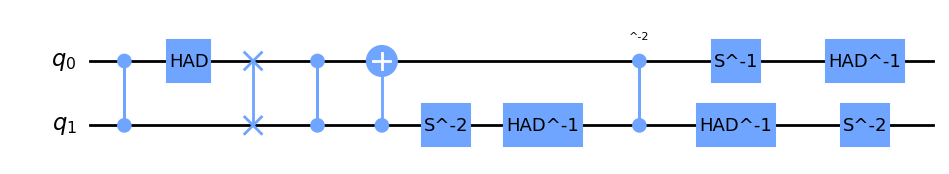

Matrix([
[0, 0, 2, 1],
[0, 2, 2, 0],
[0, 1, 0, 0],
[2, 1, 1, 2]])

In [136]:
c = lhs + rhs.adjoint()
display(c.draw())
dizx.symplectic.modulo_matrix(c.to_symplectic_matrix(),3)

In [109]:
lhs.to_symplectic_matrix()

Matrix([
[ 0, -1,  2, 0],
[-1, -1,  1, 1],
[ 0,  1, -1, 0],
[-2, -1,  0, 1]])

In [110]:
rhs.to_symplectic_matrix()

Matrix([
[ 0,  1,  0,  0],
[-1,  1, -4, -2],
[ 0, -2, -1,  0],
[ 0, -4, -4, -1]])

In [92]:
print(c.to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
quditdim 3
qreg q[2];
cz^2 q[0], q[1];
h^2 q[0];
h q[1];
cz q[0], q[1];
cx q[1], q[0];
z^-1 q[1];
s^-2 q[1];
cx^-2 q[0], q[1];
s^-2 q[1];
h^-2 q[1];
s^-2 q[1];
cx^-1 q[1], q[0];
cz^-1 q[0], q[1];
h^-1 q[1];



In [156]:
cs = simp.CliffordSimplifier(c)
cs.check_semantics_each_step = True

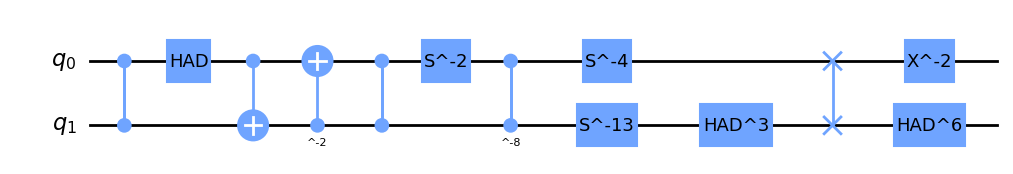

Matrix([
[0, 0, 2, 1],
[0, 2, 2, 0],
[0, 1, 0, 0],
[2, 1, 1, 2]])

In [166]:
cs.simple_optimize()

display(cs.circuit.draw())
dizx.symplectic.modulo_matrix(cs.circuit.to_symplectic_matrix(),3)

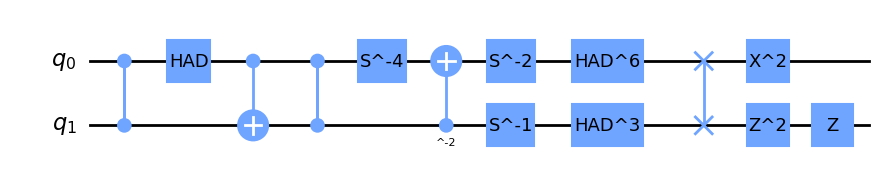

In [181]:
cs.circuit_list[-18].draw()

Push S past CX
None
        CZ(0,1)
                HAD(0)
                        CX(0,1)
                                CZ(0,1)
                                        S^-4(0)
                                                CX^-2(1,0)
                                                        S^-1(1)
                                                                HAD^3(1)
                                                                        SWAP(0,1)
                                                                                X^2(0)
                                                                                HAD^6(1)
                                                        S^-2(0)
                                                                SWAP(0,1)
                                                                        X^2(0)
                                                                        HAD^6(1)



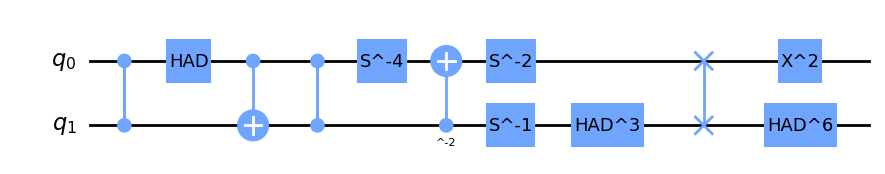

In [195]:
index = -15
print(cs.steps_done[index+1])
print(cs.dags[index])
cs.circuit_list[index].draw()

In [196]:
print(cs.circuit_list[index].to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
quditdim 3
qreg q[2];
cz q[0], q[1];
h q[0];
cx q[0], q[1];
cz q[0], q[1];
s^-4 q[0];
cx^-2 q[1], q[0];
s^-1 q[1];
h^3 q[1];
s^-2 q[0];
swap q[0], q[1];
x^2 q[0];
h^6 q[1];



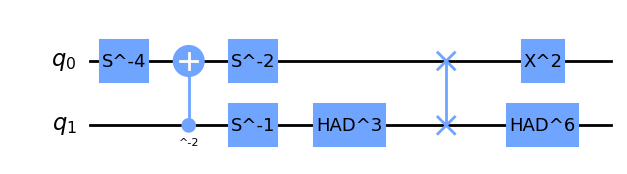

In [197]:
# TODO: This rewrite breaks the DAG structure.
c = dizx.Circuit.from_qasm_file(r'..\circuits\S_push_past_CX1.qasm')
display(c.draw())
cs2 = simp.CliffordSimplifier(c)
print(cs2.dag)
cs2.push_S_past_CX()
print(cs2.dag)

None
        S^-4(0)
                CX^-2(1,0)
                        S^-1(1)
                                HAD^3(1)
                                        SWAP(0,1)
                                                X^2(0)
                                                HAD^6(1)
                        S^-2(0)
                                SWAP(0,1)
                                        X^2(0)
                                        HAD^6(1)

None
        CX^-2(1,0)
                S^-2(0)
                        SWAP(0,1)
                                X^2(0)
                                HAD^6(1)
                CZ^-8(1,0)
                        S^-4(0)
                                SWAP(0,1)
                                        X^2(0)
                                        HAD^6(1)
                        S^-16(1)
                                Z^-4.0(1)
                                        S^-1(1)
                                                HAD^3(1)
       

In [164]:
cs.push_CZ_past_CX()

True

In [162]:
cs.push_S_past_CX()

True

In [160]:
cs.push_H_gate()

True

In [71]:
cs.transform_CX_to_SWAP()

False

In [153]:
for d in cs.steps_done[-100:]:
    print(d)

Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP
Push H^2
Push SWAP


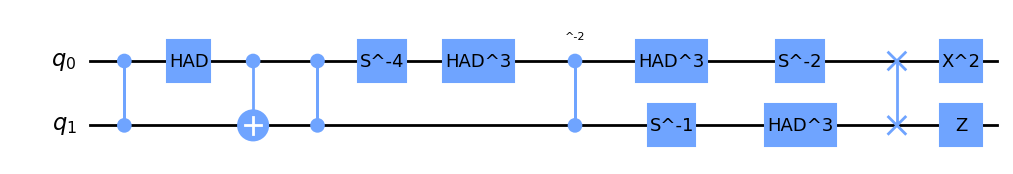

None
        CZ(0,1)
                HAD(0)
                        CX(0,1)
                                CZ(0,1)
                                        S^-4(0)
                                                HAD^3(0)
                                                        CZ^-2(0,1)
                                                                HAD^3(0)
                                                                        S^-2(0)
                                                                                SWAP(0,1)
                                                                                        Z(1)
                                                                                        X^2(0)
                                                                S^-1(1)
                                                                        HAD^3(1)
                                                                                SWAP(0,1)
                                      

In [128]:
display(cs.circuit_list[-2].draw())
print(cs.dags[-2])

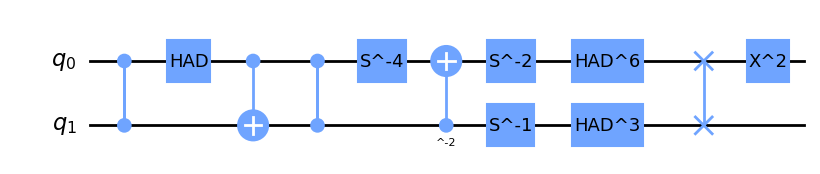

None
        CZ(0,1)
                HAD(0)
                        CX(0,1)
                                CZ(0,1)
                                        S^-4(0)
                                                CX^-2(1,0)
                                                        S^-1(1)
                                                                HAD^3(1)
                                                                        SWAP(0,1)
                                                                                X^2(0)
                                                        S^-2(0)
                                                                HAD^6(0)
                                                                        SWAP(0,1)
                                                                                X^2(0)



In [143]:
display(cs.circuit_list[-1].draw())
print(cs.dags[-1])

In [8]:
print(c.to_symplectic_matrix())
print(c2.to_symplectic_matrix())
#dizx.symplectic.compare_matrices(,c2.to_symplectic_matrix(),3)

Matrix([[1, 0, 0, 0], [-4, 1, 1, 4], [-1, 0, 1, 3], [1, 0, 0, 1]])
Matrix([[1, 0, 0, 0], [2, 1, 1, -2], [-10, 0, -1, -8], [-1, 0, 0, -1]])


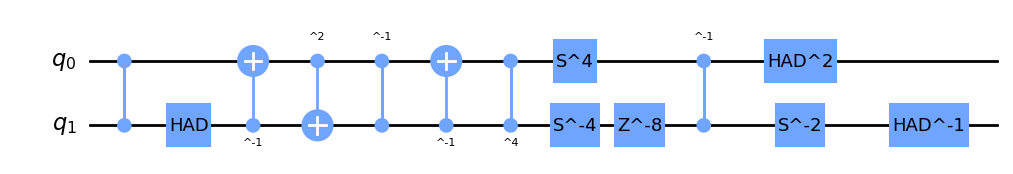

In [6]:
c2 = dizx.Circuit.from_qasm_file('../circuits/pauli_push1.qasm')
c2.draw()

In [ ]:
cs = simp.CliffordSimplifier(c)
cs.simple_optimize()
cs.push_CZ_past_CX()
cs.simple_optimize()
cs.transform_CX_to_SWAP()
cs.simple_optimize()
cs.transform_CX_to_SWAP()
cs.circuit.draw()

In [ ]:
cs.circuit.to_symplectic_matrix()

In [ ]:
c.to_symplectic_matrix()

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
cs.push_S_past_CX()

In [ ]:
print(cs.dag)

In [ ]:
"hoi"

In [ ]:
cs.display_widget()

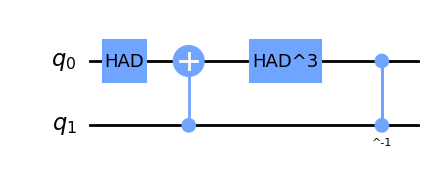

In [131]:
c = dizx.Circuit(2,3)
c += HAD(0)
c += CX(1,0)
c += HAD(0)**3
c += CZ(1,0)**-1
c.to_qiskit_rep().draw("mpl")

In [132]:
c.to_symplectic_matrix()

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]])

In [ ]:
cs2 = simp.CliffordSimplifier(c)
cs2.push_S_gate()

In [ ]:
print(cs2.dag)
cs2.circuit.to_qiskit_rep().draw("mpl")

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
StepperWidget(cs).show()

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
for circ in cs.circuit_list:
    print(circ)

In [ ]:
cs.euler_decomp()

In [ ]:
cs.euler_decomp2()

In [ ]:
cs.dag